# 教程4:MBHBs和MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *


在第四篇教程中，我们将研究MBHB波形。我们将研究如何生成波形，添加LISA响应，计算可能性，然后使用mbhb运行MCMC。

## 任务1:生成IMRPhenomHM波形


我们将从生成mbhb的IMRPhenomHM波形开始。选择合理的参数，构建波形，并在特征应变表示中绘制与LISA灵敏度曲线(`LISASens`)对应的波形。**提示**:设置`f_ref = 0.0`。您可以在波形生成后作为类的属性访问信息。这可能会更新

有用的文档:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [2]:
# imports 
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from lisatools.sensitivity import get_sensitivity

No CuPy or GPU PhenomHM module.


In [3]:
wave_gen = PhenomHMAmpPhase()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
t_ref = 1e6 # seconds
length = 1024

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

Text(0, 0.5, 'Characteristic Strain')

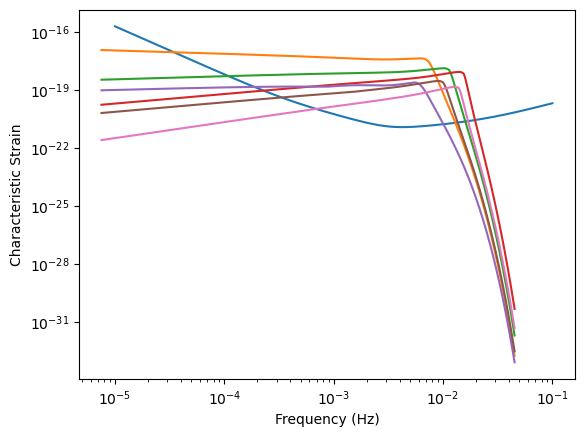

In [4]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 


plt.loglog(fn, Sn_char_strain)
for i in range(6):
    char_strain = wave_gen.freqs * wave_gen.amp[0, i]
    plt.loglog(wave_gen.freqs, char_strain)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")

## 任务2:添加响应。 


现在重复上面的任务，添加响应。在`BBHx`中，使用主波形生产类`BBHWaveformFD`自动为您添加响应。它的敏感度应该是`A1TDISens`。

有用的文档:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

In [5]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
tdi_wave_gen = BBHWaveformFD()

In [7]:
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 12.  # 1 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)

AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs
)

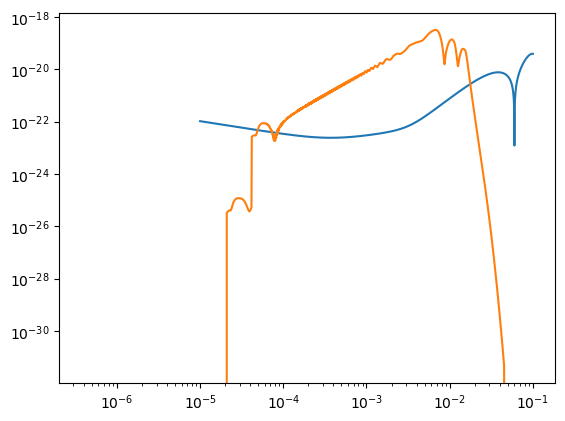

In [8]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
plt.loglog(fn, Sn_char_strain)
plt.loglog(freqs, freqs * np.abs(AET[0,0]))

## 任务3:注入一个MBHB并计算它的SNR


我们如何将`lisatools`和`bbhx`的知识结合起来。使用上面相同的方法，设置一个完整的`AnalysisContainer`并注入一个MBHB信号。计算它的信噪比。您可能需要包装MBHB波形生成以选择出第1个数组条目。

In [9]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [10]:
def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]

In [11]:
data = DataResidualArray(AET[0], f_arr=freqs)
sens_mat = AET1SensitivityMatrix(data.f_arr)
analysis = AnalysisContainer(data, sens_mat, signal_gen=wrap)

/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/root/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [12]:
analysis.snr()

3233.4754750915417


使用`calculate_signal_likelihood`计算可能性

In [13]:
analysis.calculate_signal_likelihood(
    m1 * 1.0001,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True
    # data_arr_kwargs=dict(f_arr=freqs)
)

-7.643172532320023

## 任务4: MCMC with MBHBs


现在我们将为mbhb运行MCMC。使用我们关于`Eryn`教程中的知识为mbhb运行MCMC。让我们对四个以上的参数运行它:`(m1, m2, phi_ref, t_ref)`。你可以使用`Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer)或包装器来填充固定参数。你可以使用`EnsembleSampler`的`periodic` kwarg来运行`phi_ref`作为一个周期性变量包裹在边缘。

这不会很快。对少量样本运行采样器，然后继续下一步。

In [14]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [15]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
        # data_arr_kwargs=dict(f_arr=freqs)
    )
    return ll

In [18]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [19]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

100%|██████████| 10/10 [02:36<00:00, 15.66s/it]


## 任务5:为了提高速度而添加异动


这需要很长时间才能完成一次抽样。一种加速波形的技术叫做`heterodyning`。使用参数子集包装外差似然。你也可以使用Eryn的`TransformFunction`。

有用的文档:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [20]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

No CuPy


In [21]:
# how many frequencies to use
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-0.00275878])

In [22]:
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [23]:
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

[-0.00275878] -0.0


In [24]:
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [25]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]


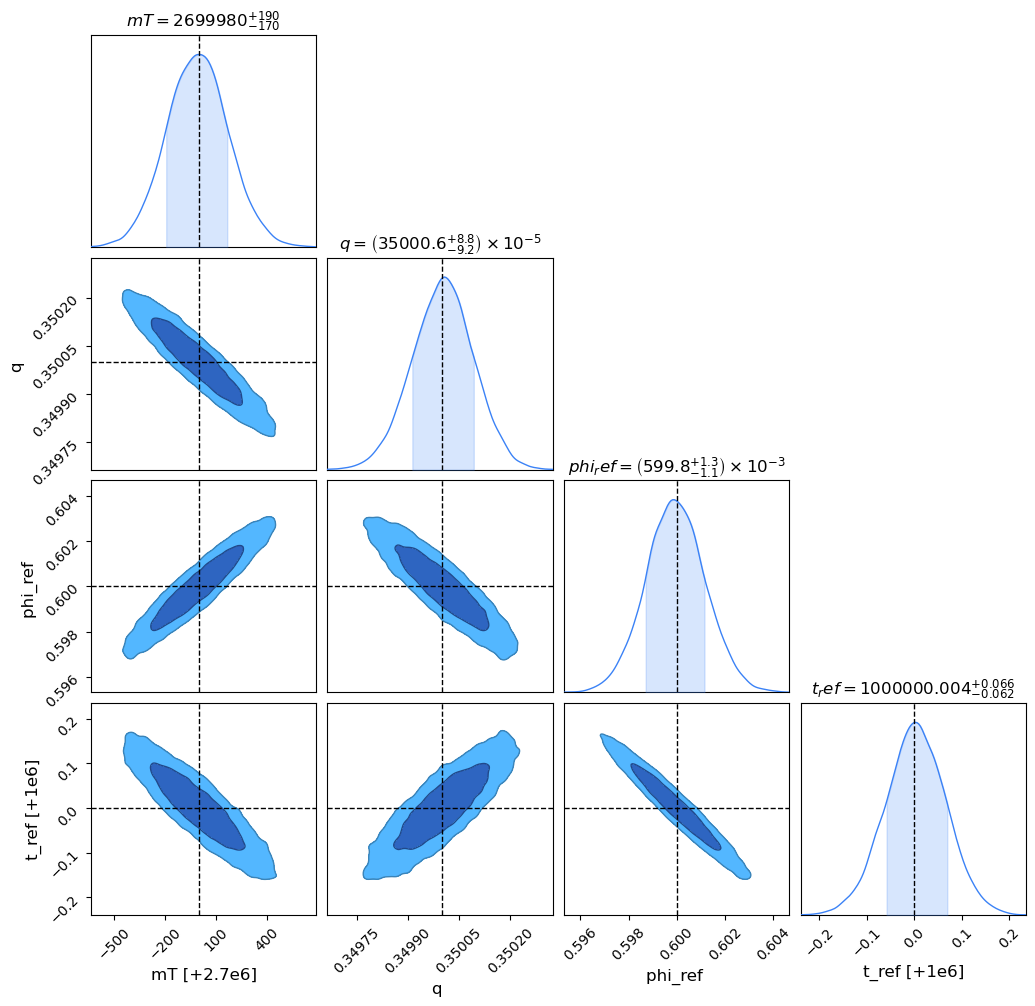

In [27]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "phi_ref": injection_params_sub[2], "t_ref": injection_params_sub[3]}))
fig = c.plotter.plot()


让我们通过先验采样来检查外差方法与基本可能性的匹配程度。你将不得不更新每次计算的参考模板，因为我们是从先验知识中提取的，可能会远离我们的真实点。你可以通过`HeterodynedLikelihood.init_heterdyne_info`来实现。

In [28]:
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))

-22306852.05923599 [-22306849.19534595] [2.86389004] [1.28386114e-07]
-6011092.381679861 [-6011092.30129136] [0.0803885] [1.33733593e-08]
-5914757.221972454 [-5914752.66440543] [4.55756702] [7.70541689e-07]
-8117562.954170864 [-8117563.47514191] [0.52097105] [6.41782581e-08]
-9108279.08085854 [-9108278.58697244] [0.4938861] [5.42238653e-08]
-12297792.968820488 [-12297792.10266926] [0.86615123] [7.0431437e-08]
-5449322.047080288 [-5449138.47596733] [183.57111296] [3.36869635e-05]
-7292898.753457653 [-7292890.57484734] [8.17861031] [1.12144849e-06]
-5782470.841739364 [-5782462.90983603] [7.93190333] [1.37171523e-06]
-9731852.682233375 [-9731843.13047631] [9.55175706] [9.8149421e-07]



设置并运行采样器。然后使用`ChainConsumer`或`corner`绘制后验图。

# 是否在更新？


# 学习总结和收获概述

## 教程内容概述
1. 背景：
研究MBHB波形，包括生成波形、添加LISA响应，计算可能性，并使用MCMC进行分析。
2. 代码准备：
导入了相应的Python库，以及LISA工具的库，
## 学习总结
在本教程中我的相关学习和接触如下：
1. 知晓了MBHB波形的生成（创建模拟波形）
2. LISA响应的添加：将LISA的仪器响应合并到模拟数据中
3. 可能性计算：计算数据与模型之间的匹配程度
4. MCMC应用：通过MCMC技术提取波形数据的参数，估计模型参数和不确定性。
